# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание и план проекта

Необходимо построить модели, предсказывающие цены на машины по их техническим характеристикам. Из моделей выбрать лучшую по метрике RMSE.
    
План:

* Сделать предобработку данных
* Проанализировать данные (выделить важные признаки, убрать ненужные)
* Построить модели
* Проанализировать результаты

## Импорт необходимых библиотек

In [1]:
!pip install catboost
!pip install lightgbm

In [2]:
pip install -U scikit-learn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn import linear_model
from time import time
plt.rcParams["figure.figsize"] = (20,20)

## Подготовка данных

In [4]:
df = pd.read_csv('sample_data/autos.csv')
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Типы данных

In [6]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

### Дубликаты

In [8]:
df.duplicated().sum()

4

In [9]:
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

In [10]:
print('VehicleType', df['VehicleType'].unique())
print('Gearbox', df['Gearbox'].unique())
print('Model', df['Model'].unique())
print('FuelType', df['FuelType'].unique())
print('Brand', df['Brand'].unique())
print('Repaired', df['Repaired'].unique())

VehicleType [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox ['manual' 'auto' nan]
Model ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore'

Неявных дубликатов не обнаружено

### Пропуски

In [11]:
df.isna().sum()/df.shape[0]*100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579487
RegistrationYear      0.000000
Gearbox               5.596772
Power                 0.000000
Model                 5.560651
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282802
Brand                 0.000000
Repaired             20.079297
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [12]:
df['VehicleType'] = df['VehicleType'].fillna('Missing')
df['Repaired'] = df['Repaired'].fillna('Missing')
df['Model'] = df['Model'].fillna('Missing')

In [13]:
df['FuelType'] = df['FuelType'].fillna(df['FuelType'].mode()[0])
df['Gearbox']= df['Gearbox'].fillna(df['Gearbox'].mode()[0])

In [14]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

## Анализ данных и признаков

In [15]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [16]:
df = df.drop('PostalCode', axis=1)

Удалили столбей PostalCode, так как он идентифицирует пользователя, а не товар, поэтому никак не влияет на цену.

In [17]:
pd.DatetimeIndex(df['DateCrawled']).year.unique()#только 2016 год

Int64Index([2016], dtype='int64', name='DateCrawled')

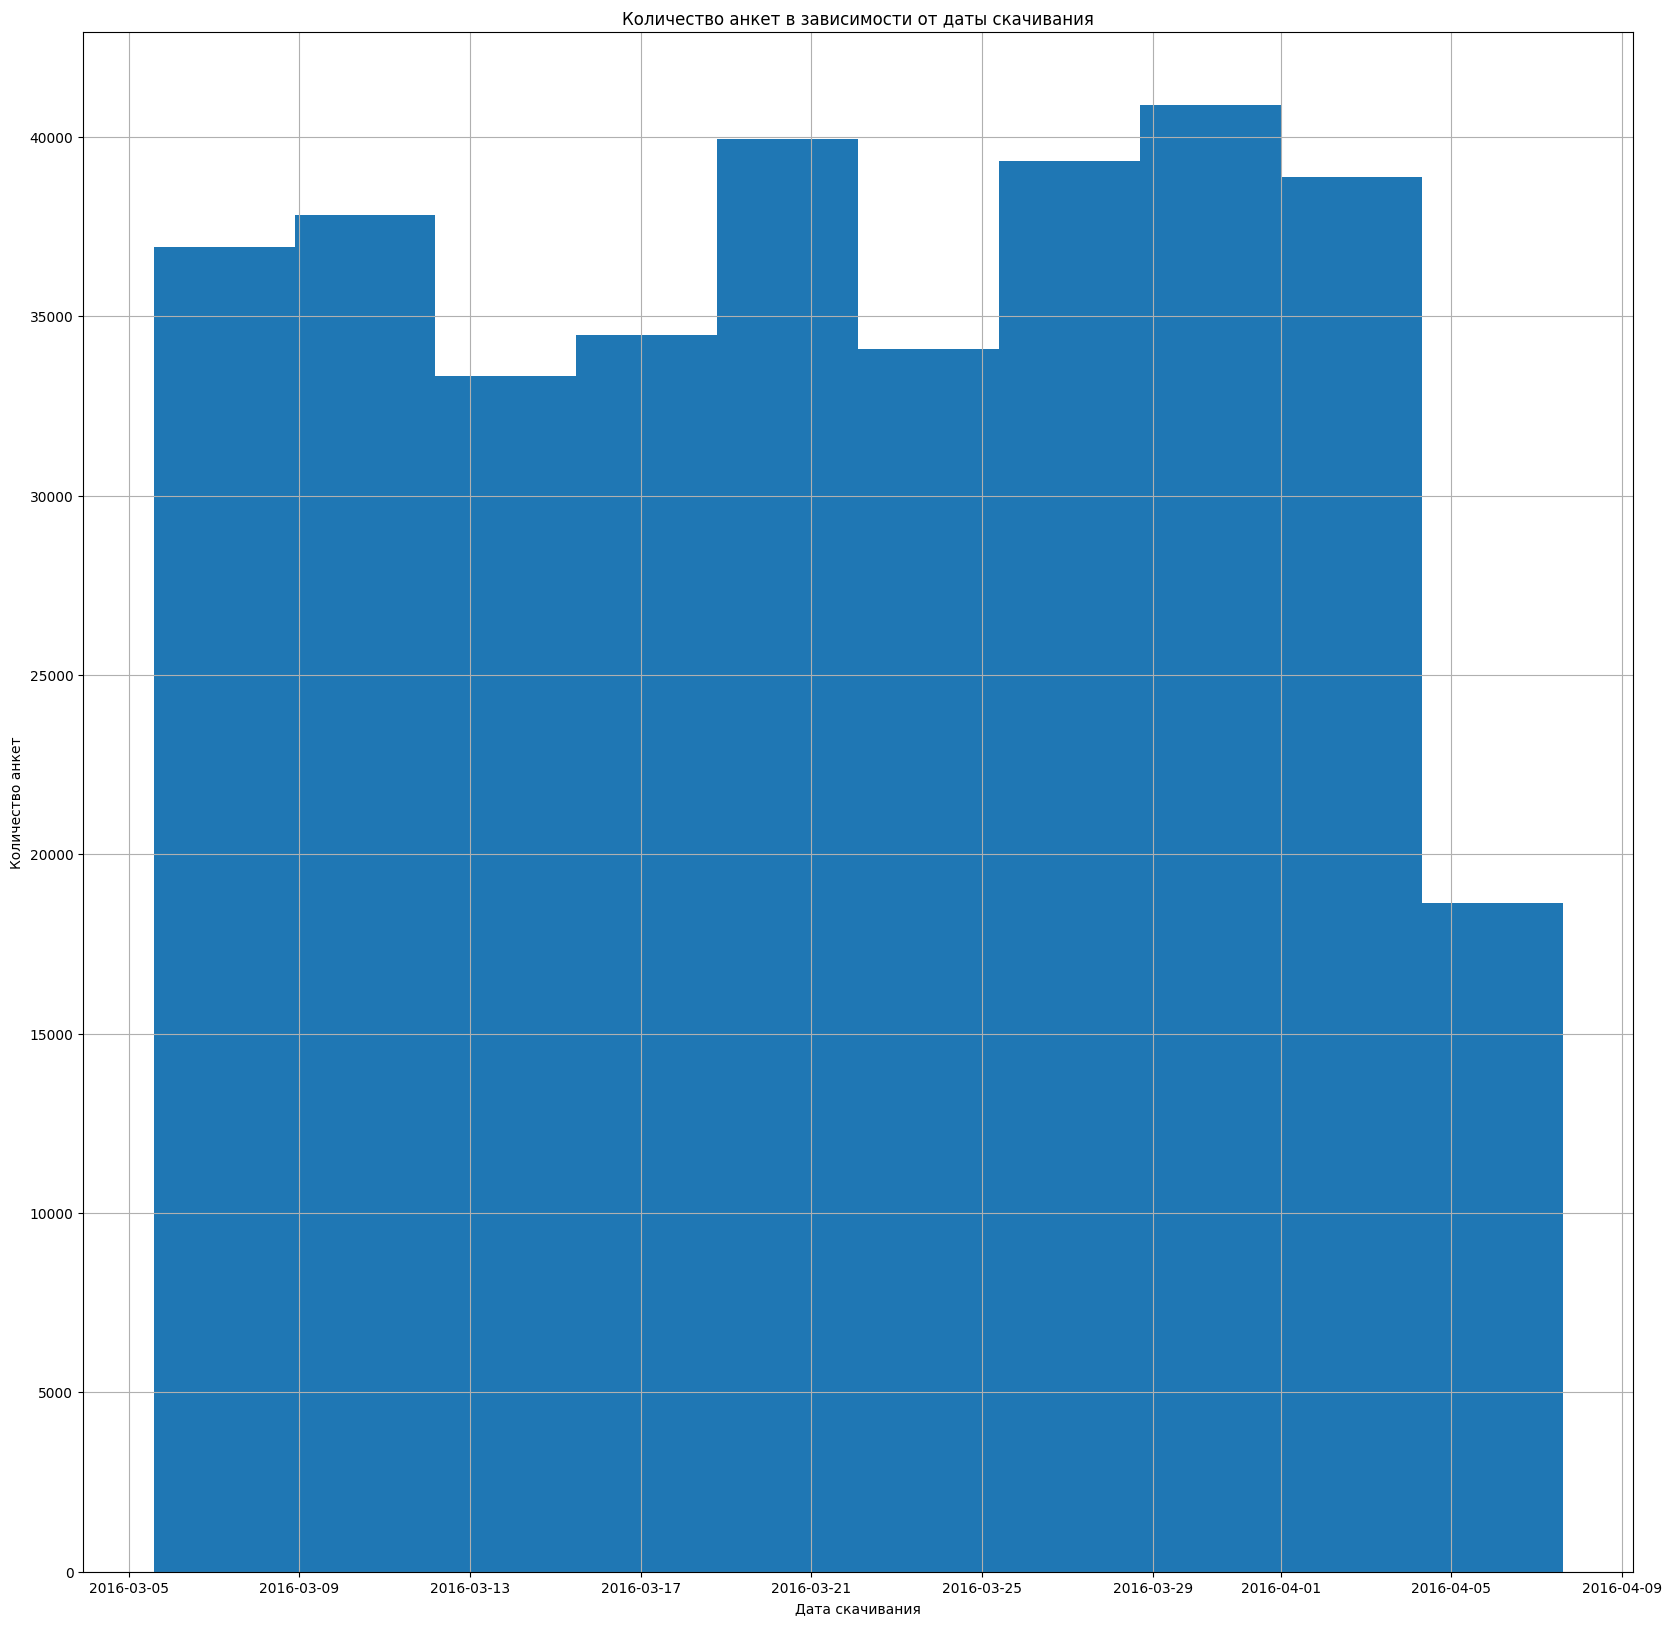

In [18]:
df['DateCrawled'].hist(figsize=(20, 20))
plt.xlabel('Дата скачивания')
plt.ylabel('Количество анкет')
plt.title('Количество анкет в зависимости от даты скачивания')
plt.show();

In [19]:
df['CrDate'] = pd.to_datetime(df['DateCrawled']).dt.date

In [20]:
df = df.drop('DateCrawled', axis=1)

Добавили столбец только с датой по DateCrawled, рассмотрим сводную таблицу средних цен за каждый день.

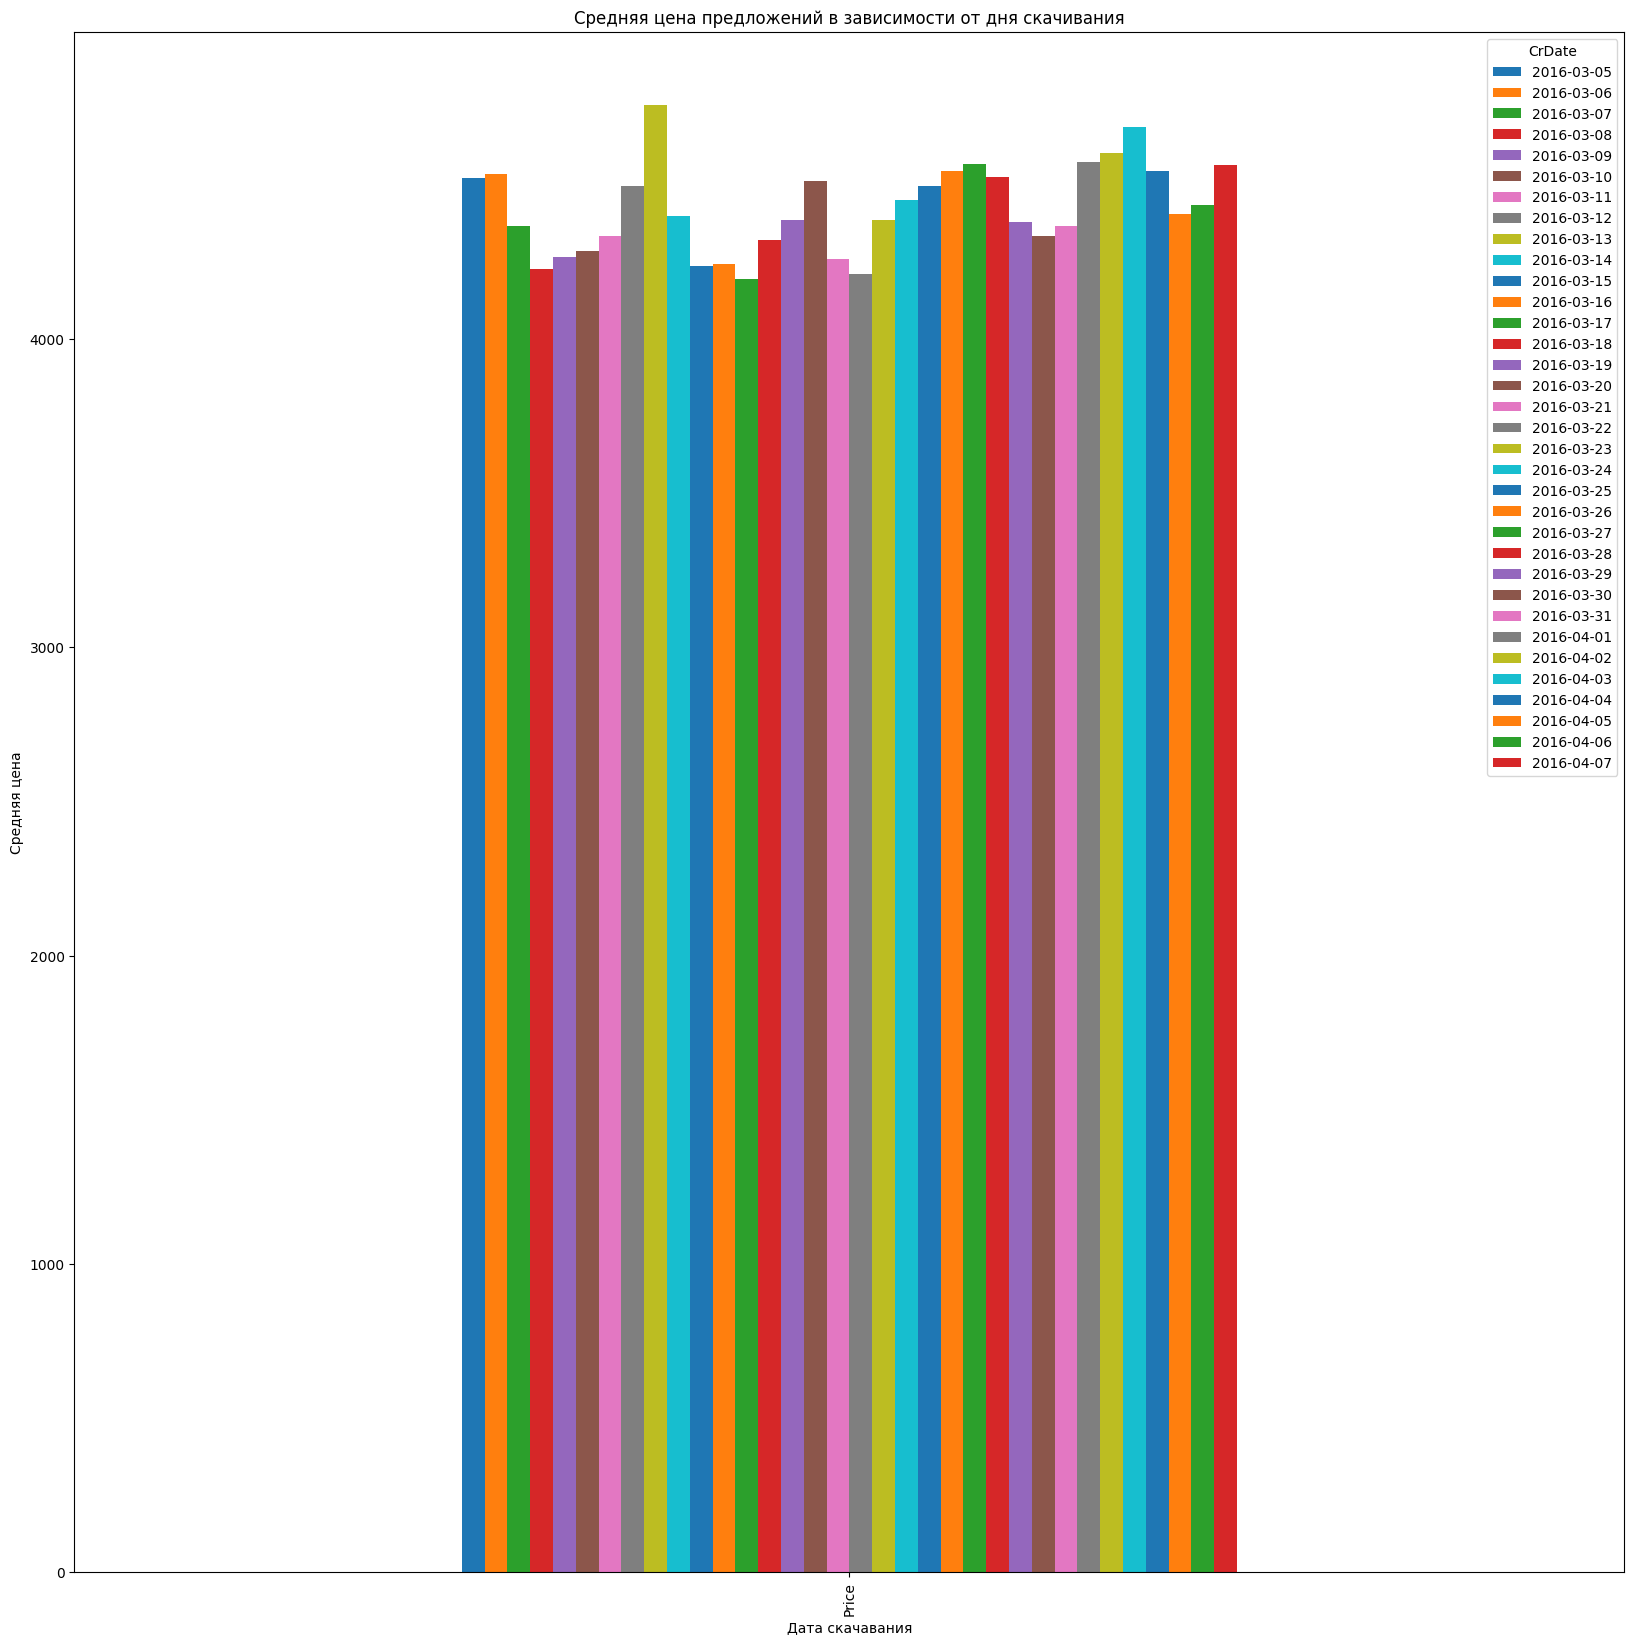

In [21]:
pd.pivot_table(df, values='Price', columns='CrDate', aggfunc='mean').plot(kind='bar')
plt.xlabel('Дата скачавания')
plt.ylabel('Средняя цена')
plt.title('Средняя цена предложений в зависимости от дня скачивания')
plt.show();

Из графика видно, что DateCrawled слабо влияет на итоговую цену автомобиля, если сравнивать по средним показателям за каждый день. Поэтому уберем столбец с полной датой, но после того, как обработаем другие столбцы с датой.

In [22]:
print(pd.DatetimeIndex(df['DateCreated']).year.unique())
print(pd.DatetimeIndex(df['DateCreated']).hour.unique())
print(pd.DatetimeIndex(df['DateCreated']).minute.unique())
pd.DatetimeIndex(df['DateCreated']).second.unique()

Int64Index([2016, 2015, 2014], dtype='int64', name='DateCreated')
Int64Index([0], dtype='int64', name='DateCreated')
Int64Index([0], dtype='int64', name='DateCreated')


Int64Index([0], dtype='int64', name='DateCreated')

Представлены данные по анкетам за три года (DateCreated). От времени можем вообще избавиться.

In [23]:
df['DateCreated'] = pd.to_datetime(df['DateCreated']).dt.date

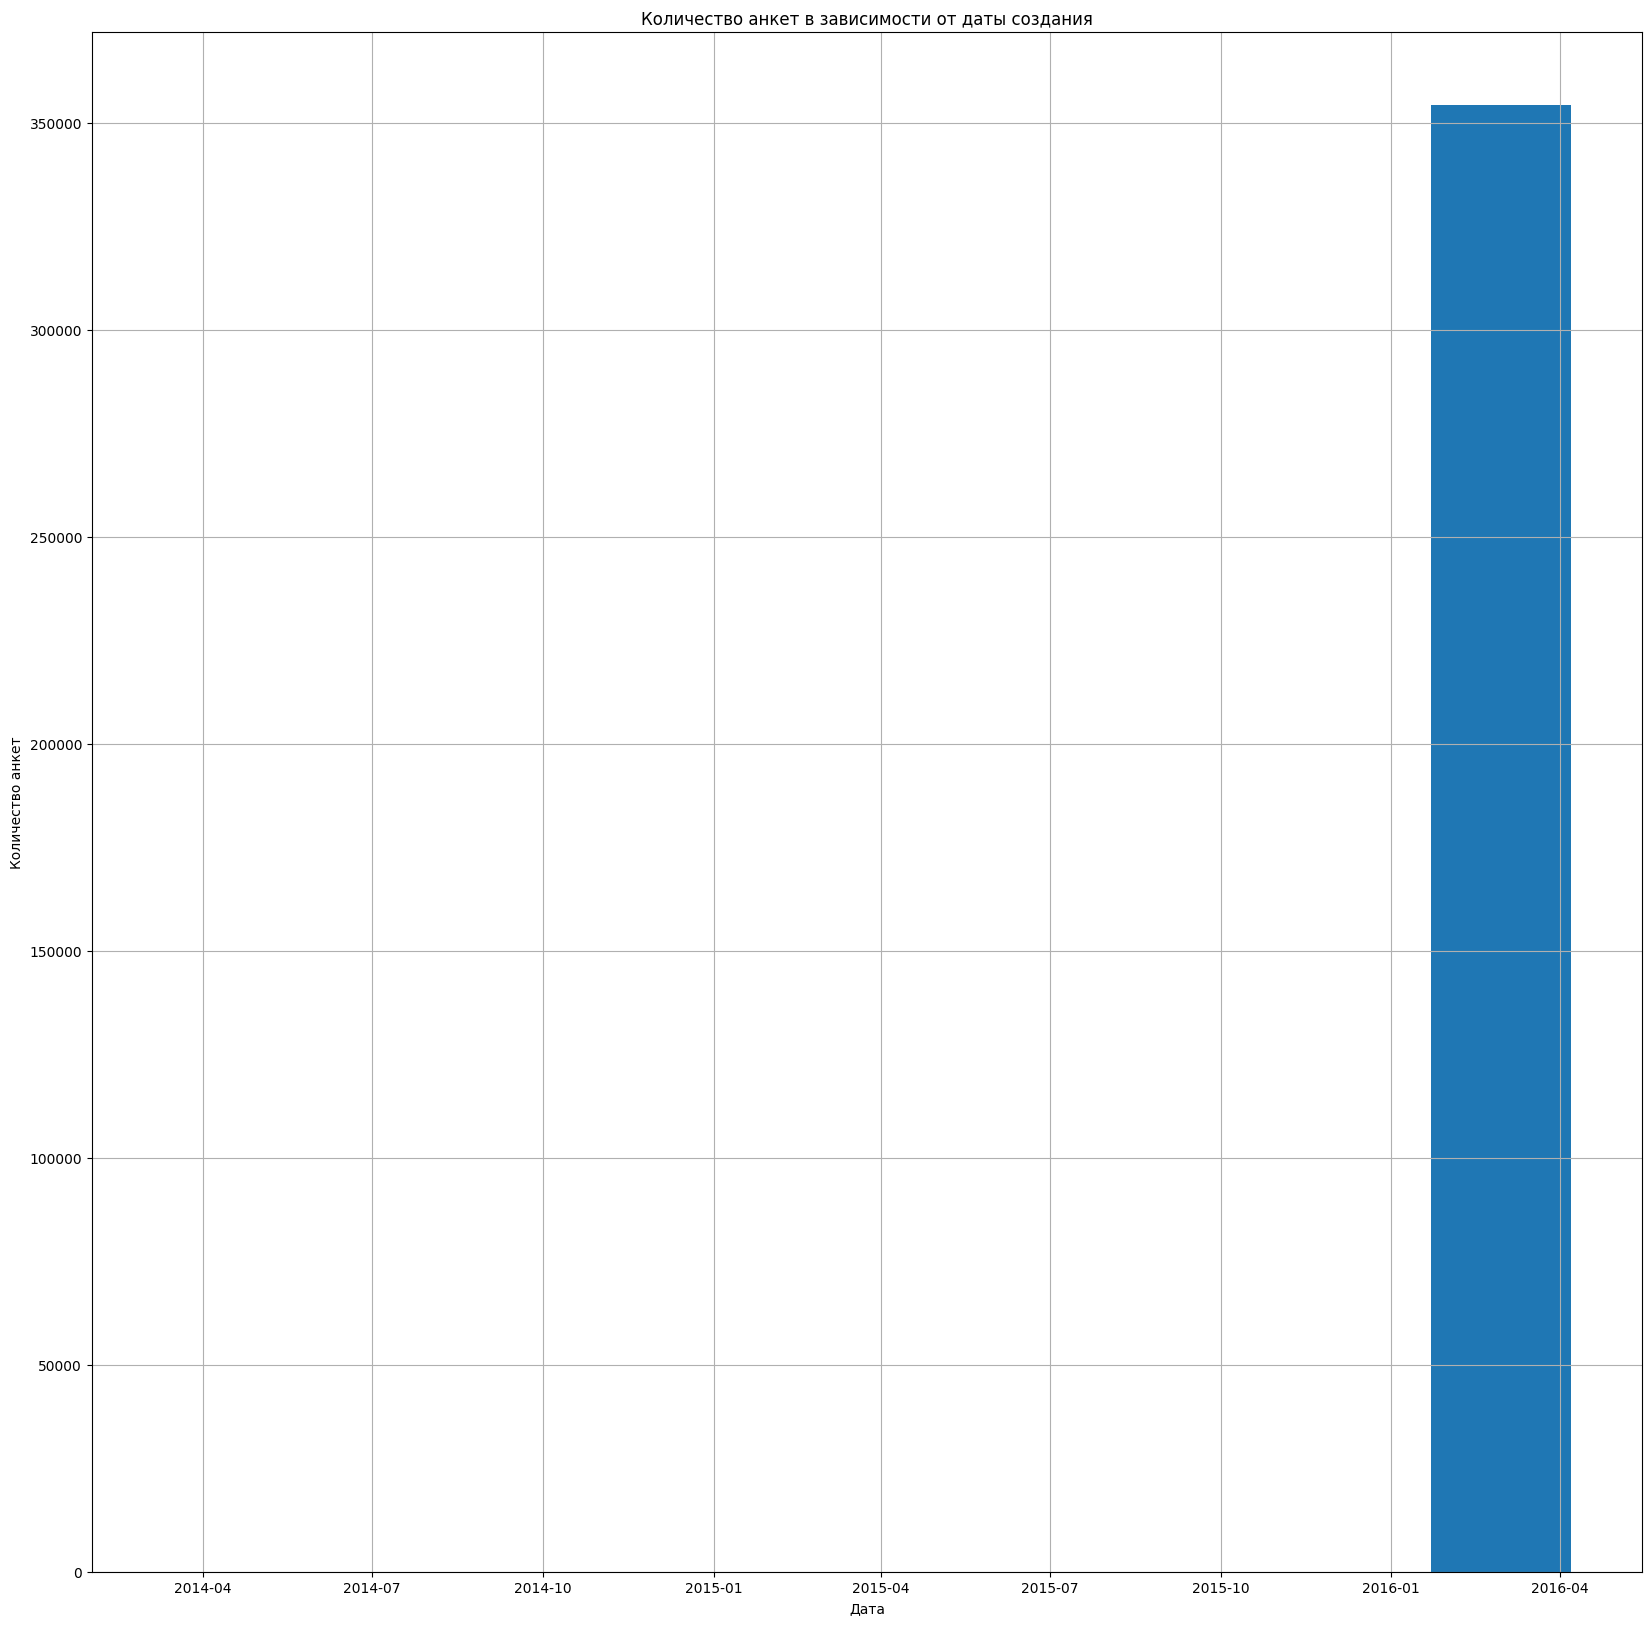

In [24]:
df['DateCreated'].hist()
plt.xlabel('Дата')
plt.ylabel('Количество анкет')
plt.title('Количество анкет в зависимости от даты создания')
plt.show();

In [25]:
df[pd.DatetimeIndex(df['DateCreated']).year<2016]['Price'].count()

26

Всего 26 анкет было создано ранее 2016 года. Удалим эти строки.

In [26]:
df=df[pd.DatetimeIndex(df['DateCreated']).year==2016]

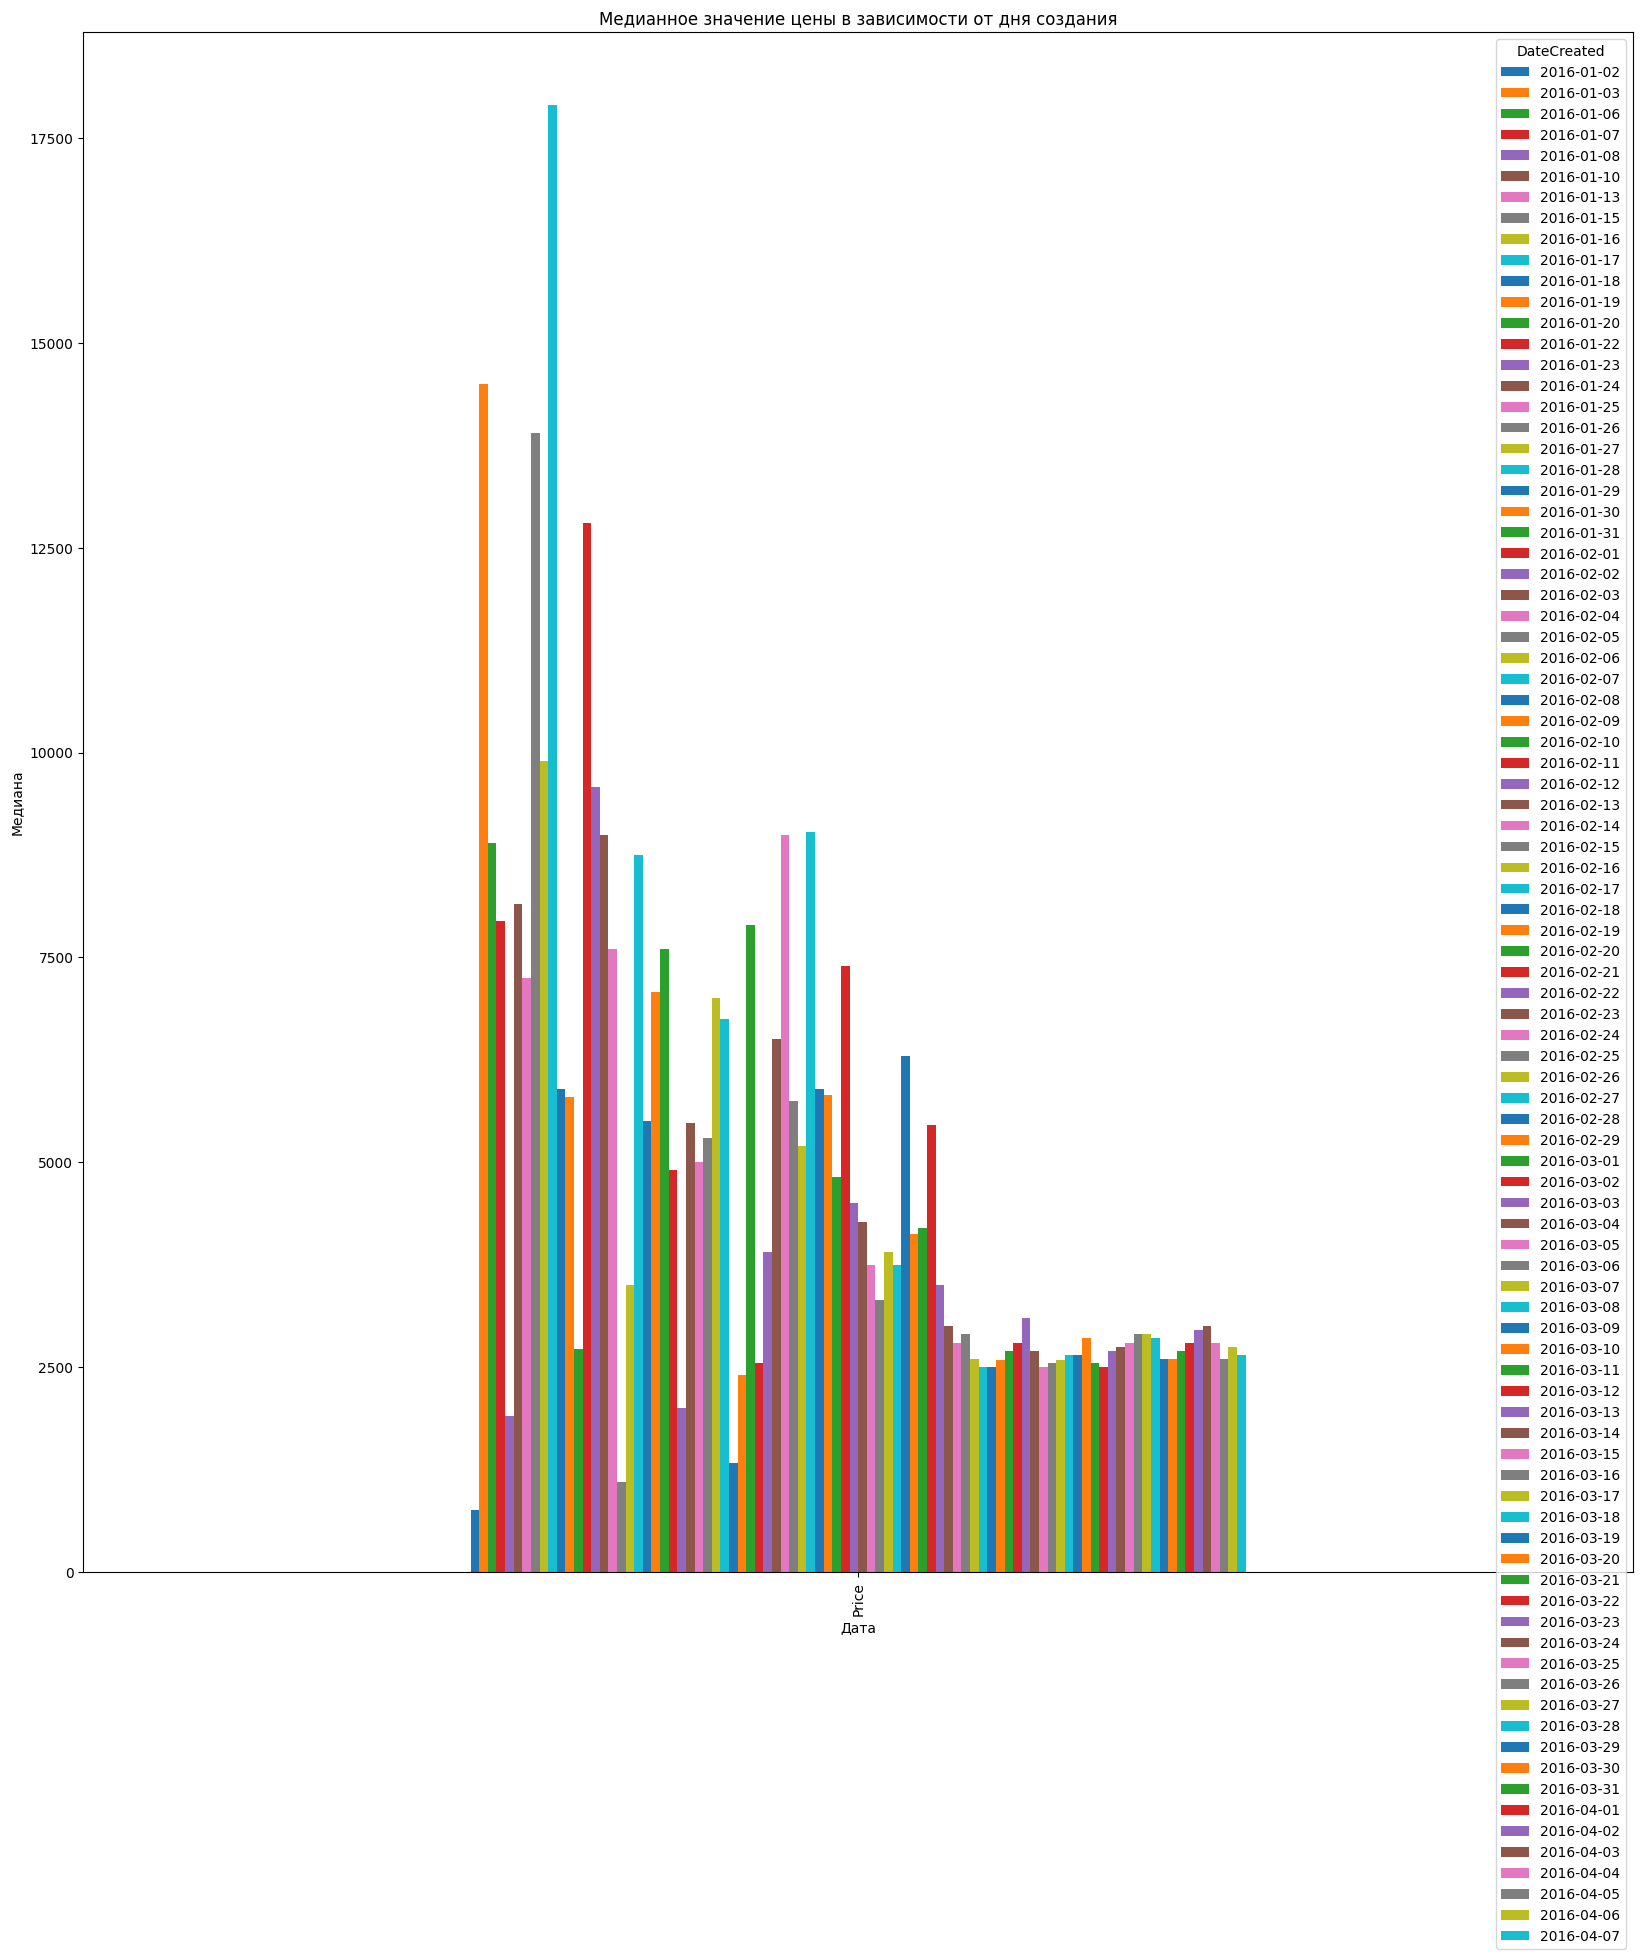

In [27]:
pd.pivot_table(df, values='Price', columns='DateCreated', aggfunc='median').plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Медиана')
plt.title('Медианное значение цены в зависимости от дня создания')
plt.show();

Видно, что цена не зависит от даты создания анкеты, поэтому удалим этот столбец.

In [28]:
df = df.drop('DateCreated', axis=1)

Рассмотрим столбец с датой последней активности пользователя. Преобразуем его только в столбец с датой.

In [29]:
df['LastSeen'] = pd.to_datetime(df['LastSeen']).dt.date

In [30]:
pd.DatetimeIndex(df['LastSeen']).year.unique()

Int64Index([2016], dtype='int64', name='LastSeen')

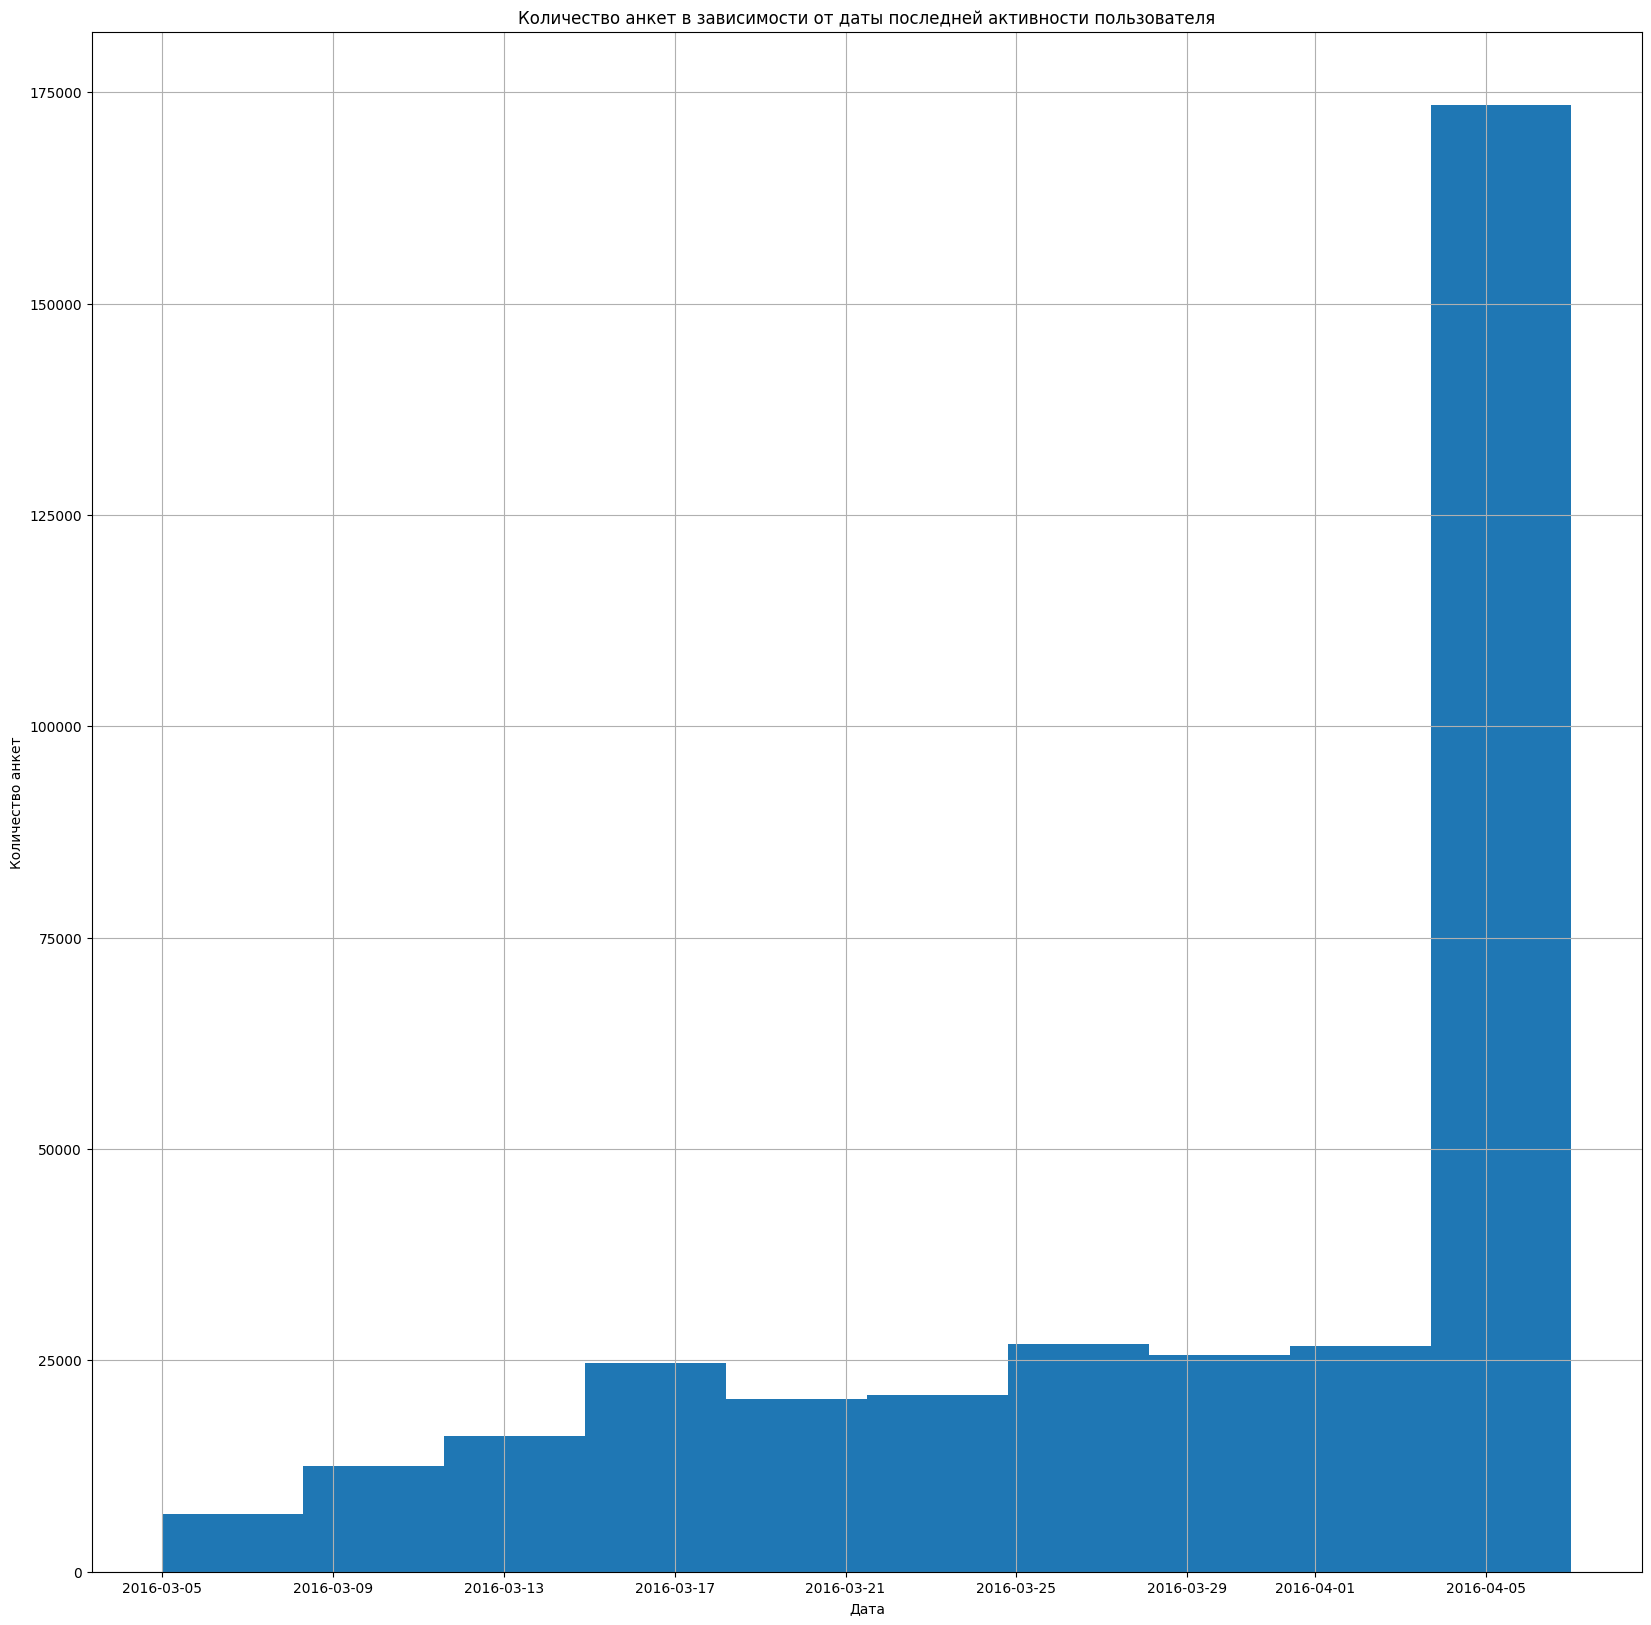

In [31]:
df['LastSeen'].hist()
plt.xlabel('Дата')
plt.ylabel('Количество анкет')
plt.title('Количество анкет в зависимости от даты последней активности пользователя')
plt.show();

Все пользователи заходили на сайт в последний раз в 2016 году.

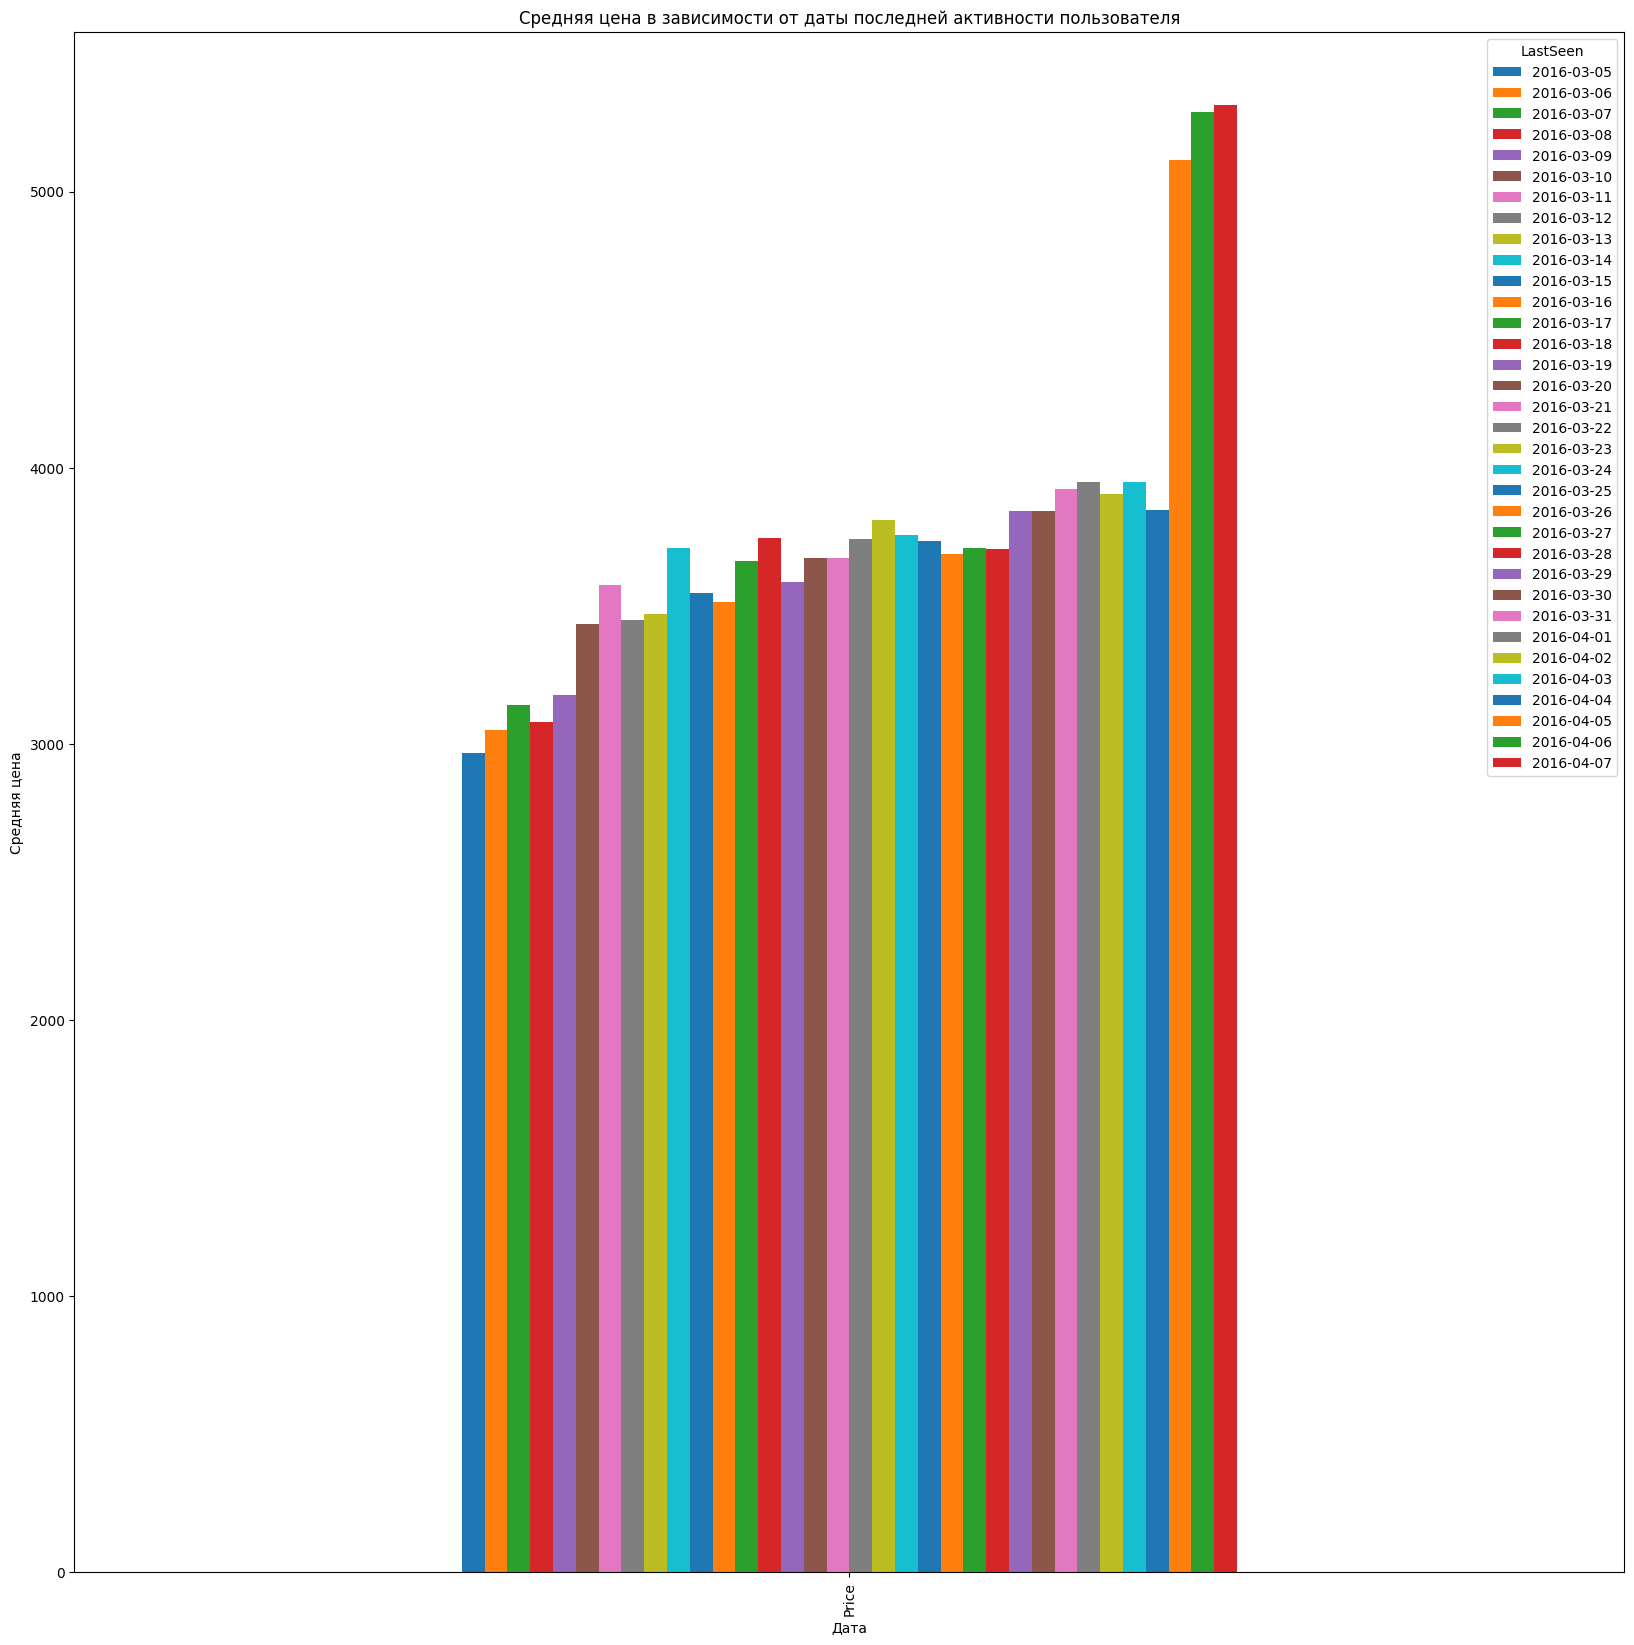

In [32]:
pd.pivot_table(df, values='Price', columns='LastSeen', aggfunc='mean').plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Средняя цена')
plt.title('Средняя цена в зависимости от даты последней активности пользователя')
plt.show();

Видим, что средняя стоимость автомобилей пользователей сайта, которые заходили позднее других, выше. Оставим этот признак. Это может говорить о том, что более активные пользователи чаще отслеживают цену и повышают свою. Для этого создадим два новых столбца с днем и месяцем последней активности.

In [33]:
df = df.drop('LastSeen', axis=1)

df['LastSeenMonth'] = pd.DatetimeIndex(df['LastSeen']).month
df['LastSeenDay'] = pd.DatetimeIndex(df['LastSeen']).day
df['LastSeenYear'] = pd.DatetimeIndex(df['LastSeen']).year

In [34]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [35]:
def checking_date(raw):
    if raw['CrDate'].year<raw['RegistrationYear']:
        return 1
    elif raw['CrDate'].year==raw['RegistrationYear']:
        if raw['CrDate'].month<raw['RegistrationMonth']:
            return 1
    return 0

In [36]:
df['date_checking'] = df.apply(checking_date, axis=1)

In [37]:
df = df[df['date_checking']==0]
df = df[df['RegistrationYear']>1800]
df = df.drop('date_checking', axis=1)

Видим, что есть строки с выбросами по году регистрации автомобиля как снизу, так и сверху. Например, дата регистрация может превосходить дату скачивания датафрейма.

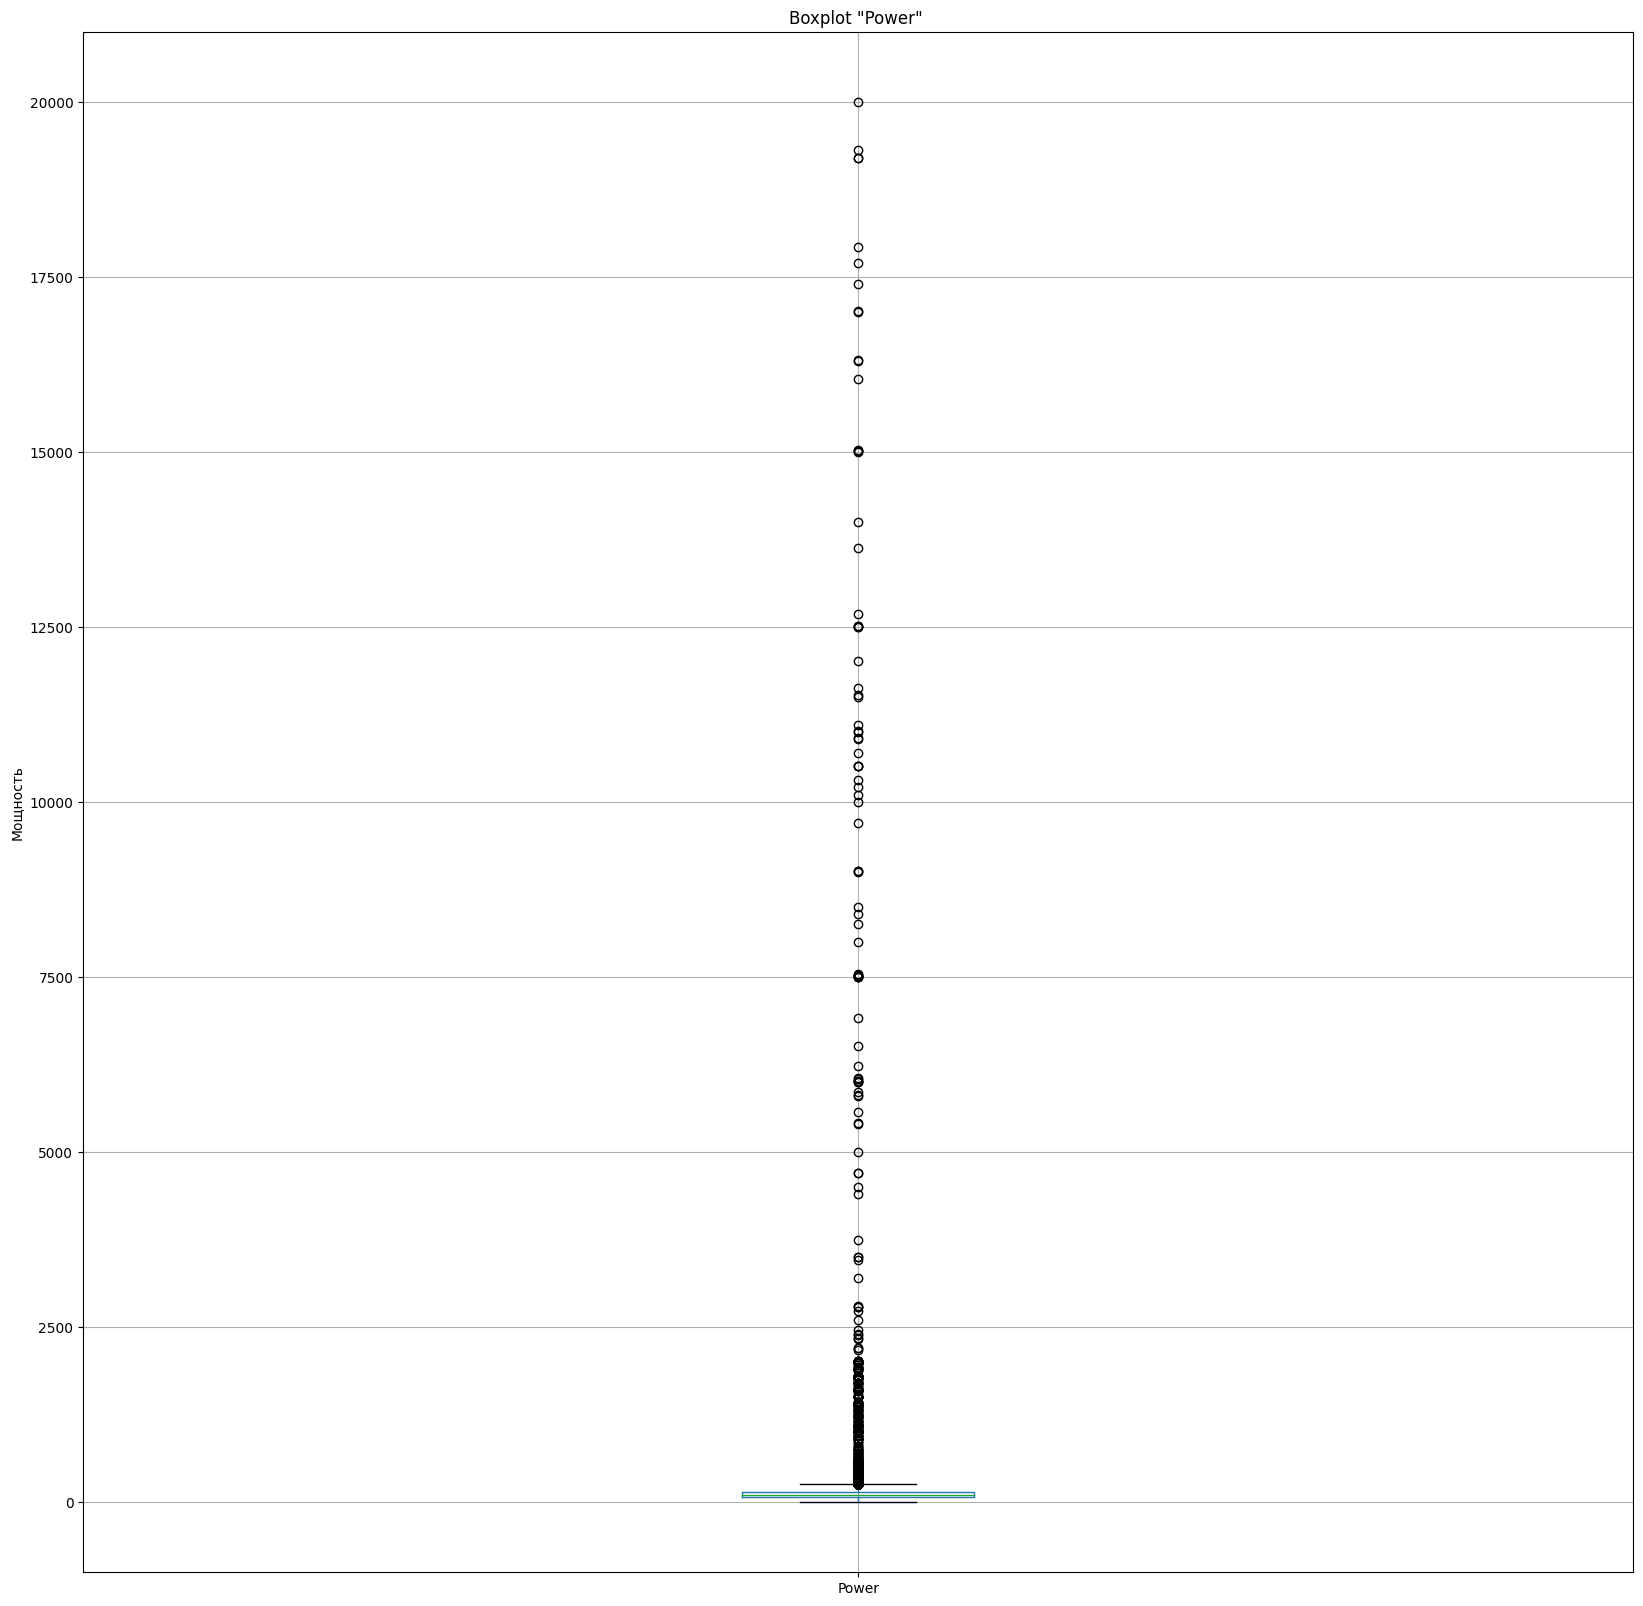

In [38]:
df.boxplot('Power')
plt.ylabel('Мощность')
plt.title('Boxplot "Power" ')
plt.show();

In [39]:
print('Null power', df[df['Power']==0]['Price'].count())
print('2000 power', df[df['Power']>2000]['Price'].count())

Null power 35180
2000 power 104


Удалим строки с выбросами по мощности, ведь пока что автомобилей с более 2000 л.с. не существует. И нулевые мощности.

In [40]:
df = df[df['Power']<=2000]
df = df[df['Power']!=0]

In [41]:
np.sort(df['Kilometer'].unique())

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000])

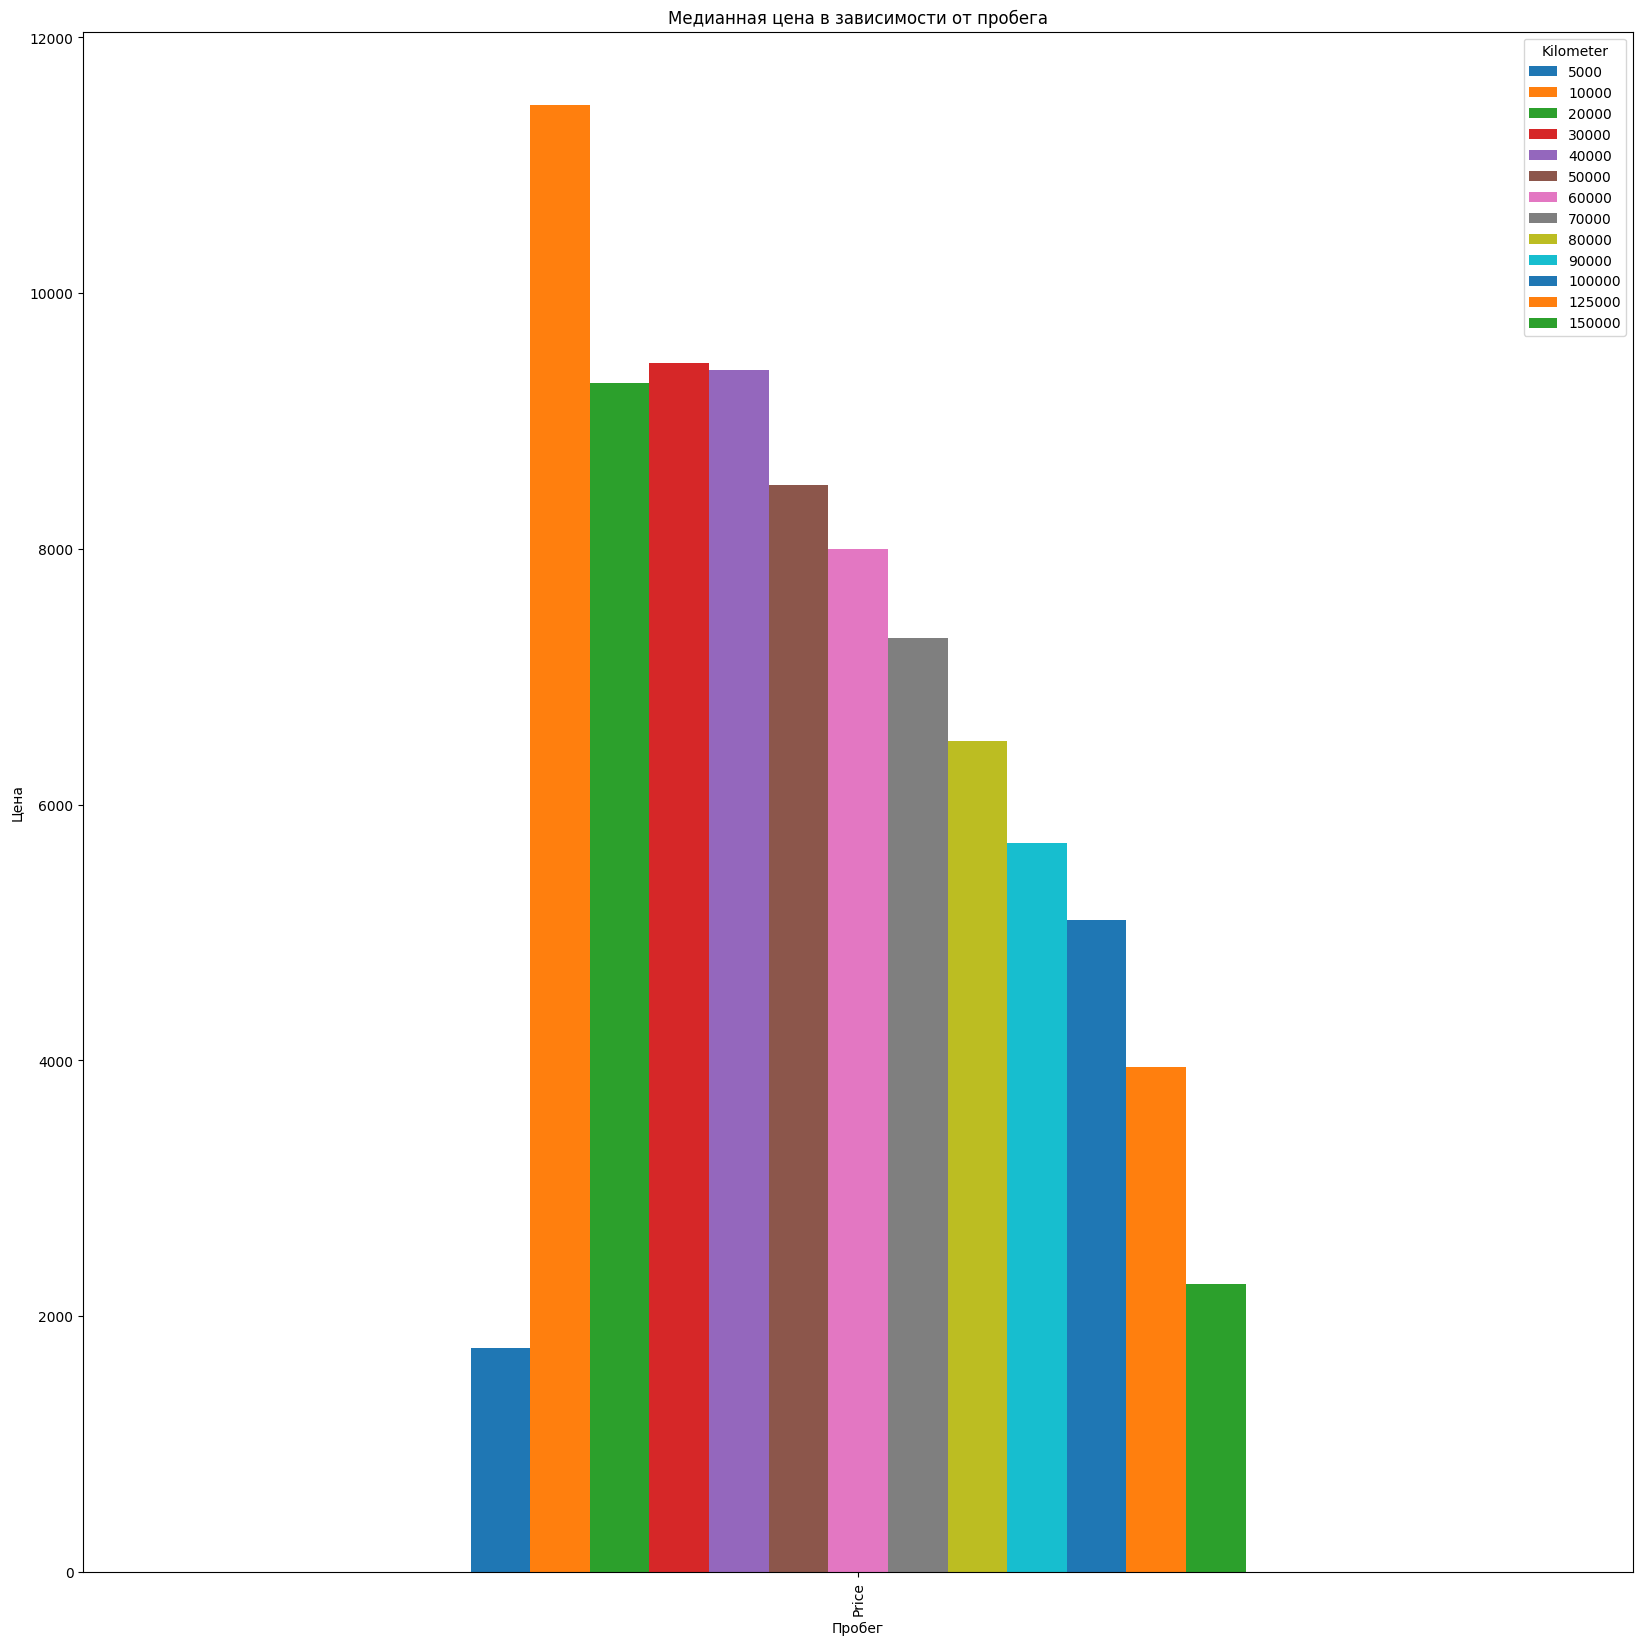

In [42]:
pd.pivot_table(df, values='Price', columns='Kilometer', aggfunc='median').plot(kind='bar')
plt.xlabel('Пробег')
plt.ylabel('Цена')
plt.title('Медианная цена в зависимости от пробега')
plt.show();

Создадим новый столбец с классификацией пробега.

In [43]:
def km_class(raw):
    if (raw['Kilometer']==5000) and (raw['Kilometer']==150000):
        return 0
    if (raw['Kilometer']==10000):
        return 1
    if (raw['Kilometer']>10000) and (raw['Kilometer']<80000):
        return 2
    else:
        return 3

In [44]:
df['km_class'] = df.apply(km_class, axis=1)

In [45]:
df = df.drop('Kilometer', axis=1)

В соответсвии с пробегом разделили на четыре класса(судя по графику сводной таблицы). Применили функцию km_class и создали новый столбец. Удалили столбец с пробегом.
Видно, что медианные значения цены у автомобилей с пробегом 50000 и 150000 примерно одинаковые. Пробег в 10000 сильно влияет на цену. Оставшийся промежуток от 20000 км до 125000 км разделим поровну на два промежутка.

In [46]:
df['RegistrationMonth'].unique()

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9])

In [47]:
df = df[df['RegistrationMonth']!=0]

Обычная опечатка с месяцем регистрации (есть 0) скорее всего.

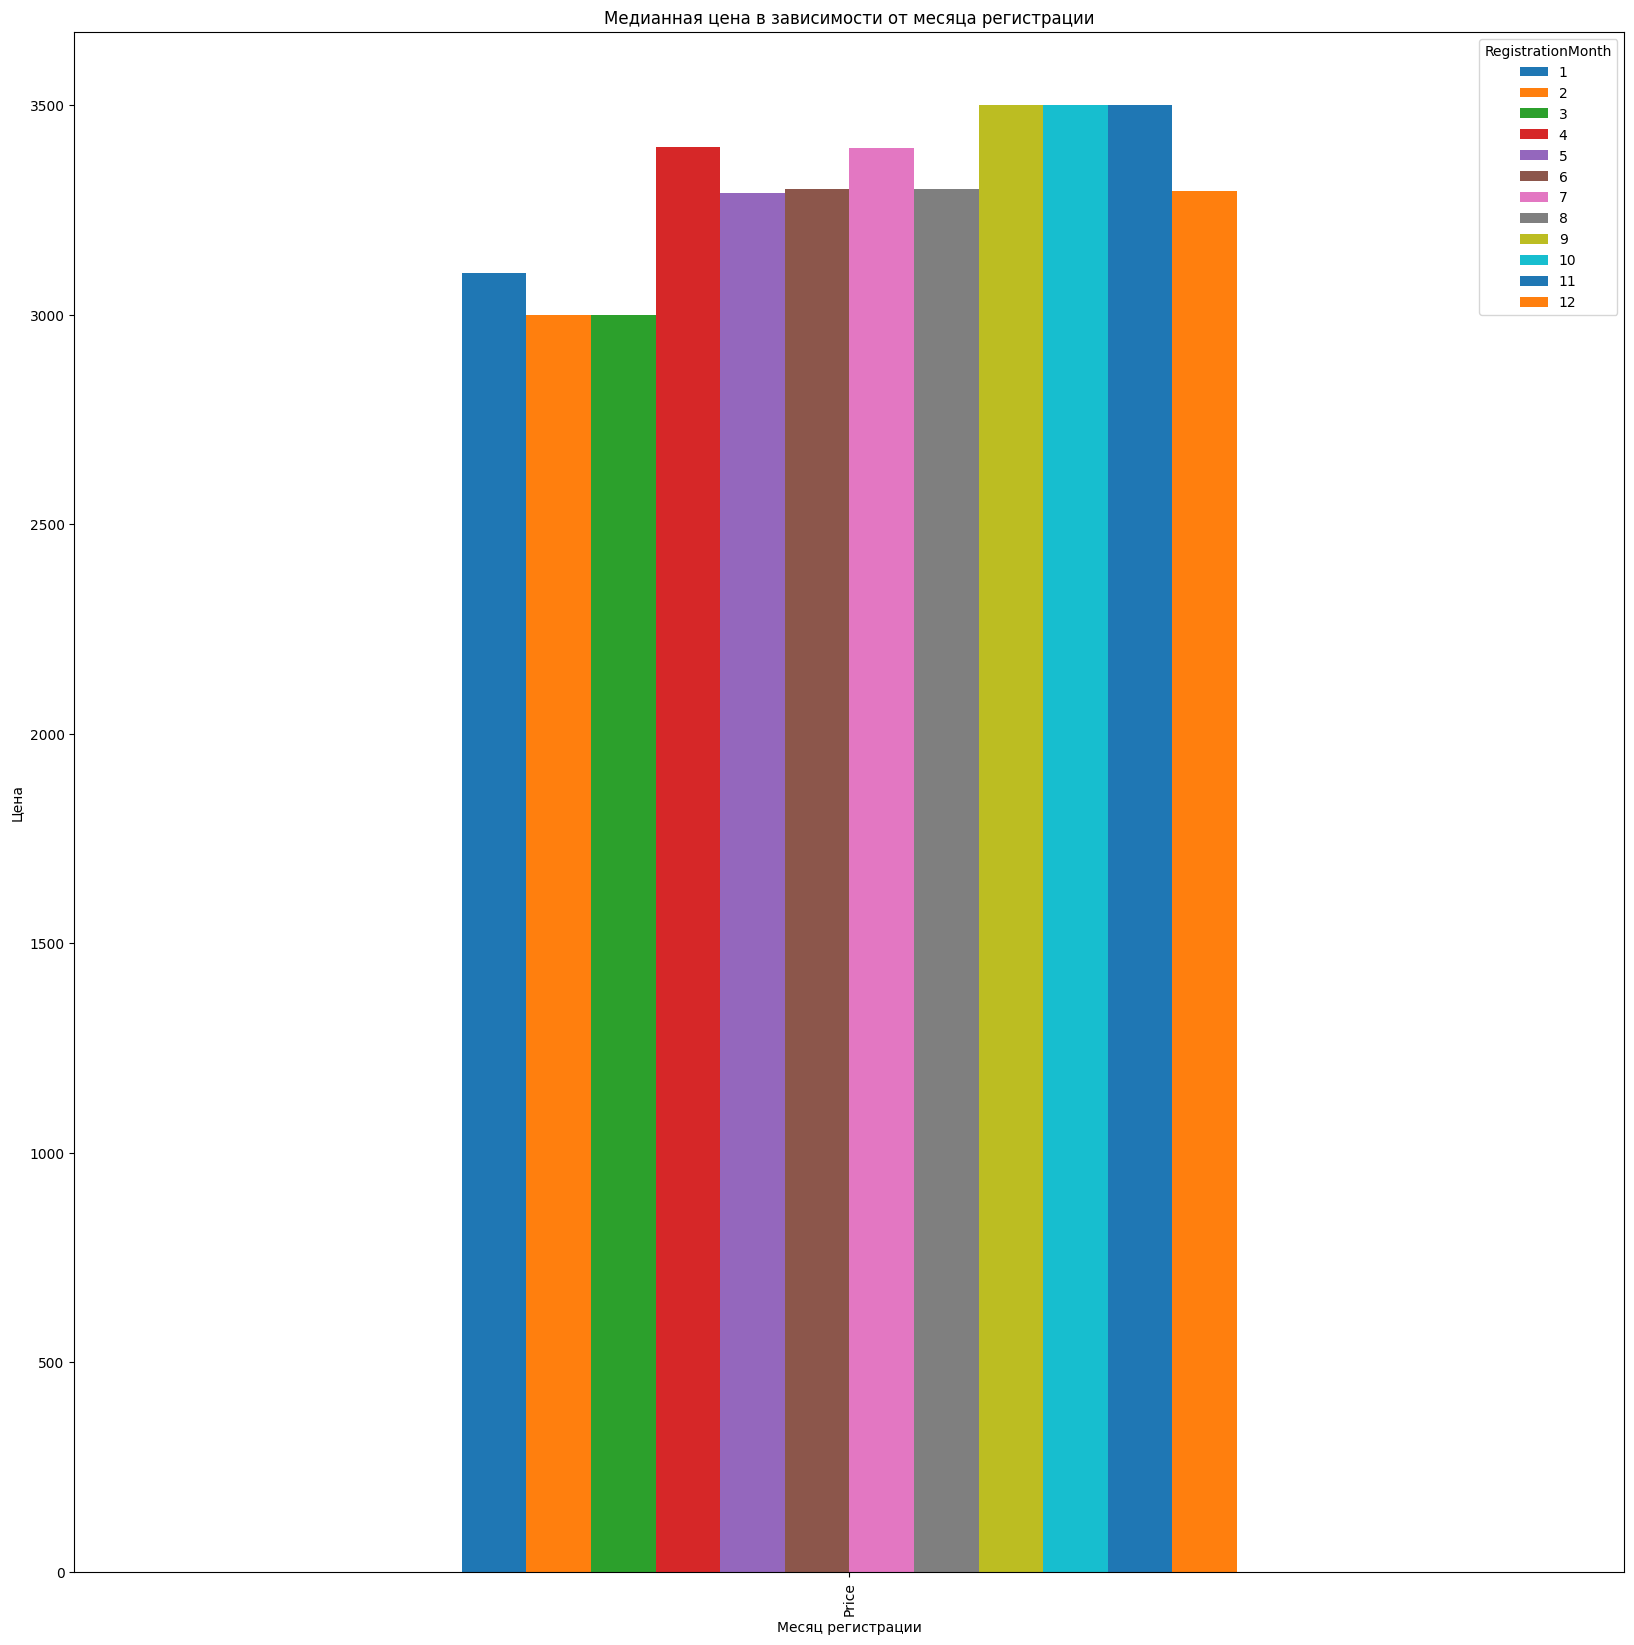

In [48]:
pd.pivot_table(df, values='Price', columns='RegistrationMonth', aggfunc='median').plot(kind='bar')
plt.xlabel('Месяц регистрации')
plt.ylabel('Цена')
plt.title('Медианная цена в зависимости от месяца регистрации')
plt.show();

Видно, что данный признак не сильно влияет на стоимость. Можно его убрать, чтобы уменьшить время обучения модели.

In [49]:
df = df.drop('RegistrationMonth', axis=1)

In [50]:
df = df.drop('CrDate', axis=1)

In [51]:
df['NumberOfPictures'].unique()

array([0])

Неинформативный столбец с количеством картинок. Удалим его.

In [52]:
df = df.drop('NumberOfPictures', axis=1)

Удалим объявления с нулевой ценой.

In [53]:
df = df[df['Price']!=0]

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274988 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             274988 non-null  int64 
 1   VehicleType       274988 non-null  object
 2   RegistrationYear  274988 non-null  int64 
 3   Gearbox           274988 non-null  object
 4   Power             274988 non-null  int64 
 5   Model             274988 non-null  object
 6   FuelType          274988 non-null  object
 7   Brand             274988 non-null  object
 8   Repaired          274988 non-null  object
 9   km_class          274988 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 23.1+ MB


In [55]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,FuelType,Brand,Repaired,km_class
1,18300,coupe,2011,manual,190,Missing,gasoline,audi,yes,3
2,9800,suv,2004,auto,163,grand,gasoline,jeep,Missing,3
3,1500,small,2001,manual,75,golf,petrol,volkswagen,no,3
4,3600,small,2008,manual,69,fabia,gasoline,skoda,no,3
5,650,sedan,1995,manual,102,3er,petrol,bmw,yes,3


In [56]:
df = df.drop_duplicates(keep='first')

In [57]:
features = df.drop(['Price'], axis=1)
target = df['Price']

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230332 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             230332 non-null  int64 
 1   VehicleType       230332 non-null  object
 2   RegistrationYear  230332 non-null  int64 
 3   Gearbox           230332 non-null  object
 4   Power             230332 non-null  int64 
 5   Model             230332 non-null  object
 6   FuelType          230332 non-null  object
 7   Brand             230332 non-null  object
 8   Repaired          230332 non-null  object
 9   km_class          230332 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 19.3+ MB


In [59]:
st = 12345

Сплитуем данные на тренировочную, валидационную, тестовую 3:1:1

In [67]:
features_train, features_test, target_train_enc, target_test_enc = (
    train_test_split(features, target, test_size=0.4, random_state=st))
features_valid, features_test, target_valid_enc, target_test_enc = (
    train_test_split(features_test, target_test_enc, test_size=0.5, random_state=st))

In [68]:
numeric=['RegistrationYear','Power', 'km_class']
non_num_feat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
                'Repaired']

Кодируем OrdinalEncoder

In [69]:
enc = OrdinalEncoder()
enc.fit(features[non_num_feat])
features_train_enc = features_train.copy()
features_valid_enc = features_valid.copy()
features_test_enc = features_test.copy()
features_train_enc[non_num_feat] = enc.transform(features_train[non_num_feat])
features_valid_enc[non_num_feat] = enc.transform(features_valid[non_num_feat])
features_test_enc[non_num_feat] = enc.transform(features_test[non_num_feat])

Кодируем OHE

In [70]:
features_train[non_num_feat].shape

(138199, 6)

In [71]:
features_train = features_train.reset_index()
features_valid = features_valid.reset_index()
features_test = features_test.reset_index()
ohe = OneHotEncoder(drop='first')
ohe.fit(features[non_num_feat])
features_train_ohe = pd.DataFrame(ohe.transform(features_train[non_num_feat]).toarray(),
             columns=ohe.get_feature_names_out())
features_train_ohe = pd.concat([features_train_ohe,features_train[numeric]],
                               axis=1)
features_valid_ohe = pd.DataFrame(ohe.transform(features_valid[non_num_feat]).toarray(),
             columns=ohe.get_feature_names_out())
features_valid_ohe = pd.concat([features_valid_ohe,features_valid[numeric]],
                               axis=1)
features_test_ohe = pd.DataFrame(ohe.transform(features_test[non_num_feat]).toarray(),
             columns=ohe.get_feature_names_out())
features_test_ohe = pd.concat([features_test_ohe,features_test[numeric]],
                               axis=1)

In [72]:
print(features_train_ohe.shape, features_train[non_num_feat].shape)
print(features_valid_ohe.shape, features_valid[non_num_feat].shape)
print(features_test_ohe.shape, features_test[non_num_feat].shape)

(138199, 308) (138199, 6)
(46066, 308) (46066, 6)
(46067, 308) (46067, 6)


## Обучение моделей

Будем подбирать гиперпараметры с помощью валидационной выборки.

In [74]:
t_l = [] #время обучения
t_p = [] #время предсказания
rmse = []
model = ['GBM', 'Linear regression', 'CatBoost']

Обучим модель LightGBM.

In [ ]:
sc = 1000000
for n_l in [20, 25, 30]:
    for depth in [15, 18, 20]:
        gbm = LGBMRegressor(metric='rmse', num_leaves=n_l, max_depth=depth, learning_rate=0.05,
                      feature_fraction=0.9, n_estimators=500, random_state=st)
        gbm.fit(features_train_enc, target_train_enc)
        rmse_val = mean_squared_error(target_valid_enc, gbm.predict(features_valid_enc))**0.5
        if rmse_val<sc:
            n_l_best = n_l
            depth_best = depth
            sc = rmse_val
print('best_score:', sc)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

In [ ]:
gbm = LGBMRegressor(metric='rmse', num_leaves=n_l_best, max_depth=depth_best, learning_rate=0.05,
                      feature_fraction=0.9, n_estimators=500, random_state=st)
start = time()
gbm.fit(features_train_enc, target_train_enc)
end = time()
gbm_time_l = (end-start)/60
t_l.append(gbm_time_l)
print('Время обучения(мин):', gbm_time_l)
start = time()
pred = gbm.predict(features_valid_enc)
end = time()
gbm_time_p = (end-start)/60
t_p.append(gbm_time_p)
print('Время предсказания(мин):', gbm_time_p)
r = mean_squared_error(target_valid_enc, pred)**0.5
rmse.append(r)
print('Лучшая метрика:', r)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Время обучения(мин): 0.34660104115804036
Время предсказания(мин): 0.029973673820495605
Лучшая метрика: 1659.5562890759454


Обучим простую линейную регрессию.

In [ ]:
lr = LinearRegression()
start = time()
lr.fit(features_train_ohe, target_train_enc)
end = time()
lr_time_l = (end-start)/60
t_l.append(lr_time_l)
print('Время обучения(мин):', lr_time_l)
start = time()
lr_pred = lr.predict(features_valid_ohe)
end = time()
lr_time_p = (end-start)/60
t_p.append(lr_time_p)
print('Время предсказания(мин):', lr_time_p)
rmse_val = mean_squared_error(target_valid_enc, lr_pred)**0.5
rmse.append(rmse_val)
print('Лучшая метрика:', rmse_val)

Время обучения(мин): 0.1891137440999349
Время предсказания(мин): 0.003320781389872233
Лучшая метрика: 2867.883693846924


Обучим CatBoost.

In [ ]:
sc = 1000000
for n_e in [500, 550]:
    for depth in [13, 16]:
        cat = CatBoostRegressor(random_state=st, learning_rate=0.05, verbose=100,
                                  depth=depth, n_estimators=n_e)

        cat.fit(features_train_enc, target_train_enc)
        rmse_val = mean_squared_error(target_valid_enc, cat.predict(features_valid_enc))**0.5
        if rmse_val<sc:
            n_e_best = n_e
            depth_best = depth
            sc = rmse_val
print('best_score:', sc)

0:	learn: 4504.9137954	total: 182ms	remaining: 1m 30s
100:	learn: 1707.4656663	total: 11.1s	remaining: 43.8s
200:	learn: 1600.3176799	total: 22.2s	remaining: 33s
300:	learn: 1533.9979675	total: 33.4s	remaining: 22.1s
400:	learn: 1486.6277318	total: 44.2s	remaining: 10.9s
499:	learn: 1448.0366588	total: 54.9s	remaining: 0us
0:	learn: 4502.6594023	total: 1.23s	remaining: 10m 15s
100:	learn: 1619.1371831	total: 1m 56s	remaining: 7m 39s
200:	learn: 1496.3773637	total: 3m 49s	remaining: 5m 41s
300:	learn: 1414.9373815	total: 5m 44s	remaining: 3m 48s
400:	learn: 1355.1741864	total: 7m 39s	remaining: 1m 53s
499:	learn: 1308.8032468	total: 9m 33s	remaining: 0us
0:	learn: 4504.9137954	total: 120ms	remaining: 1m 6s
100:	learn: 1707.4656663	total: 11.3s	remaining: 50.5s
200:	learn: 1600.3176799	total: 22.6s	remaining: 39.2s
300:	learn: 1533.9979675	total: 33.7s	remaining: 27.9s
400:	learn: 1486.6277318	total: 44.5s	remaining: 16.5s
500:	learn: 1447.6465075	total: 55.6s	remaining: 5.44s
549:	learn

In [ ]:
cat = CatBoostRegressor(random_state=st, learning_rate=0.05, verbose=10,
                                  depth=depth_best, n_estimators=n_e_best)
start = time()
cat.fit(features_train_enc, target_train_enc)
end = time()
cat_time_l = (end-start)/60
print('Время обучения(мин):', cat_time_l)
t_l.append(cat_time_l)
start = time()
pred = cat.predict(features_valid_enc)
end = time()
cat_time_p = (end-start)/60
print('Время предсказания(мин):', cat_time_p)
t_p.append(cat_time_p)
r = mean_squared_error(target_valid_enc, pred)**0.5
rmse.append(r)
print('Лучшая метрика:', r)

0:	learn: 4504.9137954	total: 122ms	remaining: 1m 6s
10:	learn: 3240.8291221	total: 1.23s	remaining: 1m
20:	learn: 2557.3470933	total: 2.31s	remaining: 58.2s
30:	learn: 2191.5279404	total: 3.38s	remaining: 56.6s
40:	learn: 1995.5545325	total: 4.45s	remaining: 55.3s
50:	learn: 1885.6922898	total: 5.49s	remaining: 53.7s
60:	learn: 1823.0255895	total: 6.58s	remaining: 52.7s
70:	learn: 1776.0583607	total: 7.66s	remaining: 51.7s
80:	learn: 1746.3153317	total: 8.76s	remaining: 50.7s
90:	learn: 1724.7681774	total: 9.88s	remaining: 49.8s
100:	learn: 1707.4656663	total: 11s	remaining: 48.8s
110:	learn: 1691.9250487	total: 12.1s	remaining: 47.7s
120:	learn: 1679.6652329	total: 13.2s	remaining: 46.8s
130:	learn: 1667.9963215	total: 14.3s	remaining: 45.6s
140:	learn: 1656.8511527	total: 15.4s	remaining: 44.6s
150:	learn: 1644.9325155	total: 16.5s	remaining: 43.6s
160:	learn: 1635.2772410	total: 17.6s	remaining: 42.6s
170:	learn: 1626.0325637	total: 18.7s	remaining: 41.5s
180:	learn: 1617.6319205	t

Видим, что быстрее всех обучалась линейная регрессия. Модели, основанные на градиентном бустинге обучаются значительно дольше. По метрике

## Анализ моделей

Проверим качество моделей на тестовой выборке.

In [ ]:
d = {'модель': model,
    'время обучения':t_l,
    'время предсказания':t_p,
    'rmse':rmse}
comp_models = pd.DataFrame(data=d)
comp_models.head()

,модель,время обучения,время предсказания,rmse
0,GBM,0.183922,0.089914,1659.556289
1,Linear regression,0.206686,0.009865,2777.298035
2,CatBoost,1.021186,0.008657,1622.060249


Из результатов видно, что самая оптимальная модель по времени предсказания и качеству это CatBoost. Она обучается дольше, чем GBM, но зато быстрее предсказывает. Протестируем ее.

In [ ]:
st = time()
pred_test_CAT = cat.predict(features_test_enc)
end = time()
print('time(min):', (end-st)/60)
print('rmse:', mean_squared_error(target_test_enc, pred_test_CAT)**0.5)

time(min): 0.003250853220621745
rmse: 1639.8789142223513


## Вывод

Таким образом я
* Обработал данные
* Проанализировал признаки, добавил новые и избавился от ненужных
* Обучил несколько моделей
* Проанализировал результаты.

Можно сделать вывод, что для конкретной задачи подойдет модель CatBoost. Она показала одну из лучших метрик качества. Модель обучается дольше, чем GBM, зато быстрее предсказывает. В конкретной задаче пользователи больше будут благодарны за быстродействие модели и качество.